#  VAR Modeling

#### Note to Readers

For a comprehensive understanding of the analyses and codes presented in this notebook, I invite you to read my in-depth Medium post. The article offers an extensive exploration of each step and concept related to Vector Autoregression (VAR) modeling, crafted in an accessible and engaging manner. 

[Mastering Forecasting: Unveiling the Power of VAR Modeling for Dynamic Time Series Prediction](https://medium.com/@lightpaper/mastering-forecasting-unveiling-the-power-of-var-modeling-for-dynamic-time-series-prediction-1b87a7d63b4b)


In [2]:
import pandas as pd
import numpy as np


## Preparing the Data

In [3]:

electricity_prices = pd.read_csv('Enefit/electricity_prices.csv', index_col=0)
gas_prices = pd.read_csv('Enefit/gas_prices.csv', index_col=0)
historical_weather = pd.read_csv('Enefit/historical_weather.csv', index_col=0)

electricity_prices = electricity_prices[['euros_per_mwh']]
electricity_prices.columns = ['electricity_price_per_mwh']
electricity_prices.index = pd.to_datetime(electricity_prices.index)
electricity_prices_daily = electricity_prices.resample('D').mean()

gas_prices ['price_per_mwh'] = gas_prices [['lowest_price_per_mwh', 'highest_price_per_mwh']].mean(axis=1)
gas_prices = gas_prices[['price_per_mwh']]
gas_prices.columns = ['gas_price_per_mwh']
gas_prices.index = pd.to_datetime(gas_prices.index)
gas_prices_daily = gas_prices.resample('D').mean(numeric_only=True)



In [5]:
historical_weather[historical_weather.data_block_id == 1]
# Given latitude and longitude of the capital of Estonia
given_latitude = 59.436962
given_longitude = 24.753574

# Calculate the Euclidean distance between coordinates
distances = np.sqrt((historical_weather['latitude'].values - given_latitude)**2 + (historical_weather['longitude'].values - given_longitude)**2)

# Find the index of the closest coordinate
closest_index = np.argmin(distances)

# Get the closest latitude and longitude
closest_latitude = historical_weather['latitude'].values[closest_index]
closest_longitude = historical_weather['longitude'].values[closest_index]

closest_latitude, closest_longitude

weather_data = historical_weather[(historical_weather.latitude == closest_latitude) & ( historical_weather.longitude == closest_longitude)]


In [6]:
weather_data.index = pd.to_datetime(weather_data.index)
daily_weather_data = weather_data.resample('D').median()

# calculate coefficient of variation for each columns accross time in the daily_weather_data DataFrame
cv = daily_weather_data.std() / daily_weather_data.mean()

# select only columns with cv > 0.51
daily_weather_data = daily_weather_data[cv[cv > 0.5].index]


# drop data_block_id
daily_weather_data = daily_weather_data.drop('data_block_id', axis=1)



# drop columns with correlation coefficient > 0.8
corr_matrix = daily_weather_data.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
daily_weather_data = daily_weather_data.drop(to_drop, axis=1)


total_data = pd.concat([electricity_prices_daily, gas_prices_daily, daily_weather_data], axis=1, join='inner')


In [8]:
total_data

,electricity_price_per_mwh,gas_price_per_mwh,temperature,rain,snowfall,cloudcover_total,cloudcover_mid,cloudcover_high,shortwave_radiation
2021-09-01,110.467083,45.775,13.35,0.0,0.0,24.5,12.5,0.0,60.5
2021-09-02,112.631250,45.955,12.55,0.0,0.0,47.0,42.5,0.0,29.0
2021-09-03,107.429583,46.125,11.85,0.0,0.0,39.0,31.5,0.0,43.5
2021-09-04,106.112917,46.550,10.05,0.0,0.0,23.0,19.0,0.0,62.0
2021-09-05,99.045417,46.440,10.25,0.0,0.0,88.0,55.0,98.0,44.0
...,...,...,...,...,...,...,...,...,...
2023-05-26,54.062083,31.600,11.75,0.0,0.0,19.0,18.0,0.0,186.0
2023-05-27,62.561667,31.200,11.15,0.0,0.0,2.0,1.5,0.0,259.5
2023-05-28,44.451250,31.100,13.70,0.0,0.0,17.0,12.0,1.0,201.0
2023-05-29,35.757083,32.570,10.85,0.0,0.0,46.5,39.0,26.5,225.0


In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# Custom color palette
colors = ["#284b63", "#461220", "#fb8500", "#003566",
           "#8ecae6", "#031926", "#468189", "#77aca2",
           "#fee440"]
# Create a custom color map
cmap = ListedColormap(colors)

# Plot using the custom color map
total_data.plot(subplots=True, figsize=(15, 15), colormap=cmap)

plt.show()


##  Stationarity check and process

In [27]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity of the time series
def check_stationarity(timeseries):
    result = adfuller(timeseries.values.flatten())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])



In [28]:
# Performing the ADF test on the resampled data
for column in total_data.columns:
    print(column)
    check_stationarity(total_data[column])
    print('\n')

electricity_price_per_mwh
ADF Statistic: -3.015656
p-value: 0.033458


gas_price_per_mwh
ADF Statistic: -1.393381
p-value: 0.585445


temperature
ADF Statistic: -1.854001
p-value: 0.354000


rain
ADF Statistic: -11.711306
p-value: 0.000000


snowfall
ADF Statistic: -7.777614
p-value: 0.000000


cloudcover_total
ADF Statistic: -3.894612
p-value: 0.002075


cloudcover_mid
ADF Statistic: -14.072460
p-value: 0.000000


cloudcover_high
ADF Statistic: -15.097853
p-value: 0.000000


shortwave_radiation
ADF Statistic: -1.463195
p-value: 0.551633




In [29]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import Holt
import matplotlib.pyplot as plt

electricity_price = total_data['electricity_price_per_mwh']
gas_price_series = total_data['gas_price_per_mwh']
temperature_series = total_data['temperature']
radiation_series = total_data['shortwave_radiation']

electricity_price_model = Holt(total_data['electricity_price_per_mwh'])
electricity_price_results = electricity_price_model.fit(smoothing_level=0.1)
electricity_price_trend = electricity_price_results.fittedvalues
electricity_price_level = electricity_price_results.level
electricity_price_residual = total_data['electricity_price_per_mwh'] - electricity_price_trend

gas_price_model = Holt(total_data['gas_price_per_mwh'])
gas_price_results = gas_price_model.fit(smoothing_level=0.1)
gas_price_trend = gas_price_results.fittedvalues
gas_price_level = gas_price_results.level
gas_price_residual = total_data['gas_price_per_mwh'] - gas_price_trend


temperature_model = Holt(total_data['temperature'])
temperature_results = temperature_model.fit(smoothing_level=0.1)
temperature_trend = temperature_results.fittedvalues
temperature_level = temperature_results.level
temperature_residual = total_data['temperature'] - temperature_trend


radiation_model = Holt(total_data['shortwave_radiation'])
radiation_results = radiation_model.fit(smoothing_level=0.1)
radiation_trend = radiation_results.fittedvalues
radiation_level = radiation_results.level
radiation_residual = total_data['shortwave_radiation'] - radiation_trend



In [30]:
check_stationarity(radiation_residual)

ADF Statistic: -7.036490
p-value: 0.000000


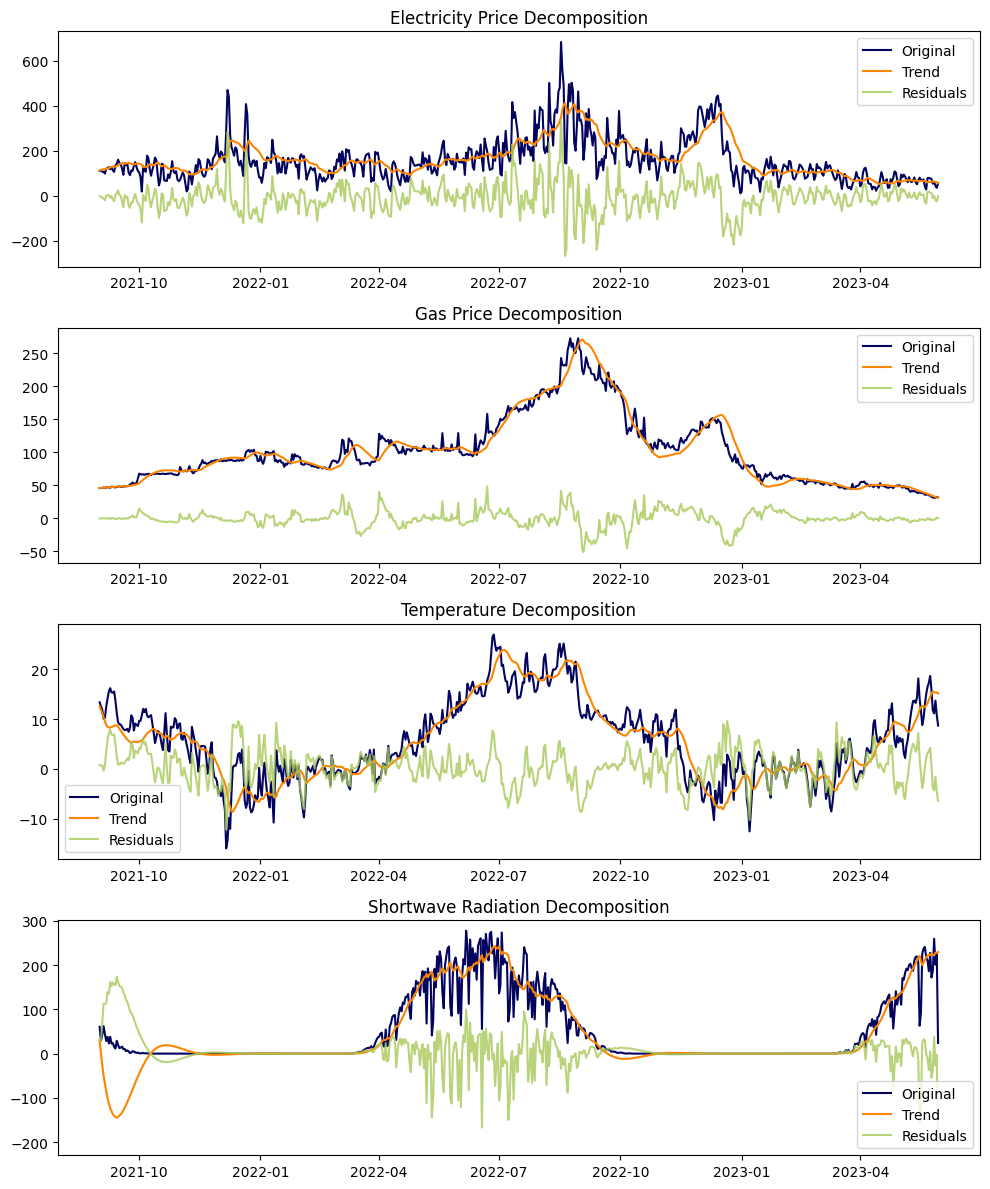

In [39]:
# Plotting the original series, trend, and residuals in a 3x1 subplot layout

plt.figure(figsize=(10, 12))

# Electricity Prices
plt.subplot(4, 1, 1)
plt.plot(electricity_price, label='Original', color='#03045e')
plt.plot(electricity_price_trend, label='Trend', color='#fb8500')
plt.plot(electricity_price_residual, label='Residuals', color='#a7c957', alpha=0.8)
plt.title('Electricity Price Decomposition')
plt.legend()

# Gas Prices
plt.subplot(4, 1, 2)
plt.plot(gas_price_series, label='Original', color='#03045e')
plt.plot(gas_price_trend, label='Trend', color='#fb8500')
plt.plot(gas_price_residual, label='Residuals', color='#a7c957', alpha=0.8)
plt.title('Gas Price Decomposition')
plt.legend()

# Temperature
plt.subplot(4, 1, 3)
plt.plot(temperature_series, label='Original', color='#03045e')
plt.plot(temperature_trend, label='Trend', color='#fb8500')
plt.plot(temperature_residual, label='Residuals', color='#a7c957', alpha=0.8)
plt.title('Temperature Decomposition')
plt.legend()

# Shortwave Radiation
plt.subplot(4, 1, 4)
plt.plot(radiation_series, label='Original', color='#03045e')
plt.plot(radiation_trend, label='Trend', color='#fb8500')
plt.plot(radiation_residual, label='Residuals', color='#a7c957', alpha=0.8)
plt.title('Shortwave Radiation Decomposition')
plt.legend()

plt.tight_layout()
plt.show()


In [59]:
check_stationarity(electricity_price_residual)
check_stationarity(gas_price_residual)
check_stationarity(temperature_residual)
check_stationarity(radiation_residual)

ADF Statistic: -5.439392
p-value: 0.000003
ADF Statistic: -6.996652
p-value: 0.000000
ADF Statistic: -8.616074
p-value: 0.000000
ADF Statistic: -7.036490
p-value: 0.000000


## Determining the Order of VAR

In [42]:
import pandas as pd
from statsmodels.tsa.api import VAR


electricity_price_residual.name = 'electricity_price_residual'
gas_price_residual.name = 'gas_price_residual'
temperature_residual.name = 'temperature_residual'
radiation_residual.name = 'radiation_residual'

data_for_var = pd.concat([total_data[['rain','snowfall', 'cloudcover_total', 'cloudcover_mid', 'cloudcover_high']],
                           electricity_price_residual, gas_price_residual, temperature_residual, radiation_residual], axis=1, join='inner')

# Fitting a VAR model
model = VAR(data_for_var)

# Determining the optimal lag order
lag_order_results = model.select_order(maxlags=10)
print(lag_order_results.summary())


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        30.26       30.32   1.387e+13       30.29
1        26.99      27.63*   5.258e+11      27.24*
2       26.94*       28.16  5.037e+11*       27.42
3        27.03       28.82   5.502e+11       27.73
4        27.12       29.48   5.997e+11       28.03
5        27.18       30.11   6.381e+11       28.32
6        27.24       30.75   6.797e+11       28.60
7        27.32       31.40   7.409e+11       28.91
8        27.38       32.04   7.869e+11       29.19
9        27.50       32.73   8.898e+11       29.53
10       27.59       33.39   9.763e+11       29.84
--------------------------------------------------


## Estimating the VAR Model

In [44]:
# Assuming 'data_for_var' contains the relevant time series data
model = VAR(data_for_var)

# Fitting the model with the chosen lag order
model_fitted = model.fit(2,ic='aic', trend='ct')

In [45]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jan, 2024
Time:                     10:51:45
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    28.2066
Nobs:                     635.000    HQIC:                   27.4344
Log likelihood:          -16484.0    FPE:                5.03253e+11
AIC:                      26.9442    Det(Omega_mle):     3.80696e+11
--------------------------------------------------------------------
Results for equation rain
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.017785         0.006727            2.644           0.008
trend                                -0.000020         0.000012           -1.627           0.1

## Diagnostic Checking

In [46]:
from statsmodels.stats.stattools import durbin_watson

# Compute Durbin-Watson statistics
dw_stats = durbin_watson(model_fitted.resid)

for col, stat in zip(data_for_var.columns, dw_stats):
    print(f'{col}: {stat}')




rain: 2.013408772844978
snowfall: 2.004398098599701
cloudcover_total: 2.0329513773103702
cloudcover_mid: 2.016264979038024
cloudcover_high: 2.00034290119527
electricity_price_residual: 2.001847215750999
gas_price_residual: 2.007175675548042
temperature_residual: 1.974926155609499
radiation_residual: 2.0071430816620675


In [47]:
import statsmodels.api as sm

# Jarque-Bera test
jb_test = sm.stats.jarque_bera(model_fitted.resid)
print(f'Jarque-Bera test p-value: \n {jb_test[1]}')



Jarque-Bera test p-value: 
 [0.00000000e+000 0.00000000e+000 1.31862685e-001 4.57953149e-014
 5.71881369e-016 4.84264359e-196 0.00000000e+000 4.49604827e-013
 0.00000000e+000]


## Forecasting with VAR

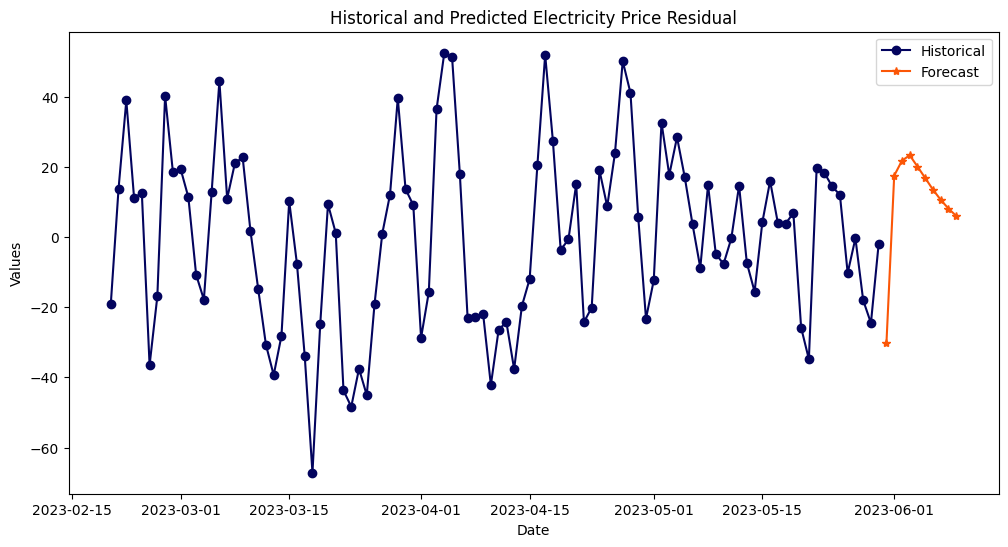

In [56]:
import matplotlib.pyplot as plt

# Forecasting
forecast_steps = 10  # Number of steps to forecast ahead
forecast = model_fitted.forecast(model_fitted.endog, steps=forecast_steps)

forecast_df = pd.DataFrame(forecast, index=pd.date_range(start=data_for_var.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D'), columns=data_for_var.columns)

# Concatenate the predicted and last 50 observations of historical data for 'electricity_price_residual'
concatenated_data = pd.concat([data_for_var['electricity_price_residual'].tail(50), forecast_df['electricity_price_residual']])

# Plot the concatenated data
plt.figure(figsize=(12, 6))
plt.plot(data_for_var.index[-100:], data_for_var['electricity_price_residual'].tail(100), label='Historical', color='#03045e',marker = 'o')
plt.plot(forecast_df.index, forecast_df['electricity_price_residual'], label='Forecast', color='#fb5607',marker = '*')
plt.title('Historical and Predicted Electricity Price Residual')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [204]:
# # Forecasting with confidence intervals
#  # Number of steps to forecast ahead
# forecast_steps = 10 
# forecast, lower, upper = model_fitted.forecast_interval(model_fitted.endog, steps=forecast_steps, alpha=0.05)

# # Creating DataFrame for forecast and confidence intervals
# forecast_index = pd.date_range(start=data_for_var.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
# forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_for_var.columns)

# # Plotting forecast with confidence intervals for 'electricity_price_residual'
# plt.figure(figsize=(12, 6))
# plt.plot(data_for_var.index[-50:], data_for_var['electricity_price_residual'].tail(50), label='Historical', color='blue', marker='o')
# plt.plot(forecast_df.index, forecast_df['electricity_price_residual'], label='Forecast', color='orange', marker='*')
# plt.title('Historical and Predicted Electricity Price Residual with Confidence Interval')
# plt.xlabel('Date')
# plt.ylabel('Values')
# plt.legend()
# plt.show()


## Predicting the level and trend of the main series


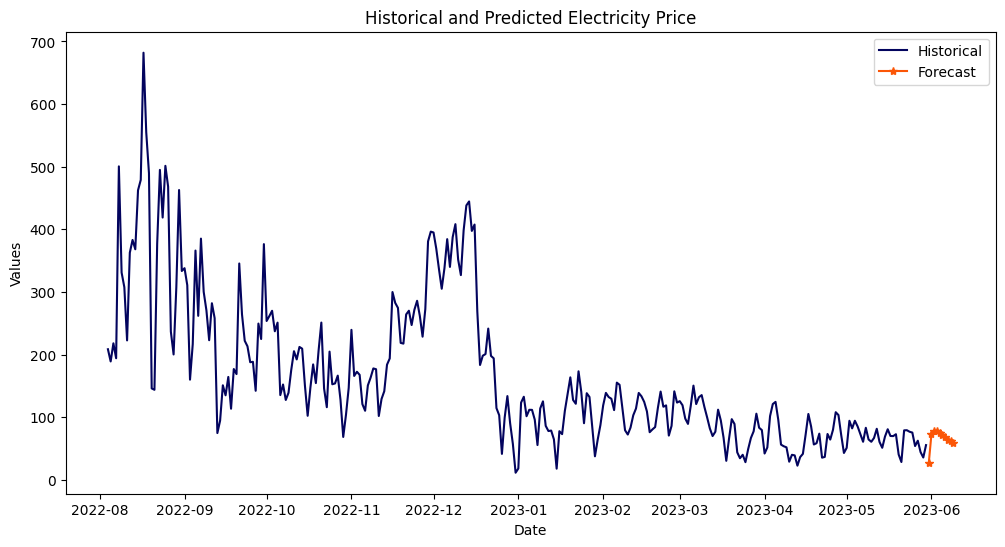

In [57]:
electricity_price = total_data['electricity_price_per_mwh']

# the fitted Holt model 
electricity_price_model = Holt(total_data['electricity_price_per_mwh'])
electricity_price_results = electricity_price_model.fit(smoothing_level=0.1)
electricity_price_trend = electricity_price_results.fittedvalues
electricity_price_level = electricity_price_results.level
electricity_price_residual = total_data['electricity_price_per_mwh'] - electricity_price_trend


# Forecasting the trend component
forecast_steps = 10  # Number of steps to forecast ahead

# Forecasting future trend values
electricity_price_trend_forecast = electricity_price_results.forecast(steps=forecast_steps)

# Creating a date range for the forecast
electricity_price_trend_forecast_index = pd.date_range(start=electricity_price_trend.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')

# Creating a DataFrame for the forecasted trend
electricity_price_trend_forecast_df = pd.DataFrame(electricity_price_trend_forecast, index=electricity_price_trend_forecast_index, columns=['electricity_price_trend_forecast'])

# sum the predicted trend and predicted residual values to get the final forecast
forecast_df['electricity_price_residual_final'] = forecast_df['electricity_price_residual'] + electricity_price_trend_forecast_df['electricity_price_trend_forecast']


# Plotting the final forecast of original electricity_price
plt.figure(figsize=(12, 6))
plt.plot(electricity_price[-300:], label='Historical', color='#03045e')
plt.plot(forecast_df.index, forecast_df['electricity_price_residual_final'], label='Forecast', color='#fb5607', marker='*')
plt.title('Historical and Predicted Electricity Price')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()